# CNN Tutorial

### Introduction

In this tutorial, we will train a CNN to classify a popular classification image database called CIFAR-10. We will start with a basic model, and keep on extending to further complicated models. Then we will evaluate these approaches and try out different augmentation techniques.

<img src="images/cifar10.png">
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images." https://www.cs.toronto.edu/~kriz/cifar.html

https://pytorch.org/tutorials/beginner/ptcheat.html

### Load Torch

In [1]:
import torch
import numpy as np

### GPU Availability

In [2]:
gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('Training on GPU.')
else:
    print('Training on CPU!')

Training on CPU!


In [33]:
history_plot = {}

def history_updater(name, history_plot, train_loss, val_loss):
    if name in history_plot:
        history_plot[name][0].append(train_loss)
        history_plot[name][1].append(val_loss)

    else:
        history_plot[name] = [],[]
        history_plot[name][0].append(train_loss)
        history_plot[name][1].append(val_loss)

### Data Loader

In [1]:
# Load CIFAR from torchvision datasets with it's dataloader
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Normalize data to torch.FloatTensor
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

# # 

# Solution or part 2

transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


data_dir = 'data/'
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
nb_classes = len(classes)
img_rows, img_cols, channels = 32, 32, 3  # input image dimensions for the cifar10 dataset

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform_test)
# Validation Size
valid_size = 0.2

# Create a random sample for the batches
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(0)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data Loader
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


NameError: name 'np' is not defined

### Visualize Dataset

In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(train_loader)

images, labels = dataiter.next()
images = images.numpy() # convert images to numpy format for matplotlib to view

# plot the images in the batch, along with the label of the image
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])


### Building the network

To build the CNN network that would classify this dataset we would use Convolutional, Maxpooling and then would experiment with using Dropout layers to prevent over fitting. We will start off with a 3 convolutional network, then expand it to an AlexNet-like architecture and compare.

output = int((in_size - kernel_size + 2*(padding)) / stride) + 1


In [21]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 32x32x3 image tensor)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        # torch.nn.MaxPool2d(kernel_size, stride, padding) – applies max pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (64 * 4 * 4 -> 500)
        # torch.nn.Linear(in_features, out_features) – fully connected layer (multiply inputs by learned weights)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
#         self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        # Image reduced to 4 x 4 due to 3 pooling layers ( 32/(2*3) )
        x = x.view(-1, 64 * 4 * 4)
        
        # add dropout layer
#         x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
#         x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
model.cuda()
print(model)

#############################################################
#############################################################


# import torch.nn as nn
# import torch.nn.functional as F

# # define the CNN architecture
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#         # convolutional layer (sees 32x32x3 image tensor)
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
#         # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#         self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        
#         # max pooling layer
#         # torch.nn.MaxPool2d(kernel_size, stride, padding) – applies max pooling
#         self.pool = nn.MaxPool2d(2, 2)
        
#         # linear layer (64 * 4 * 4 -> 500)
#         # torch.nn.Linear(in_features, out_features) – fully connected layer (multiply inputs by learned weights)
#         self.fc1 = nn.Linear(128 * 2 * 2, 500)
#         # linear layer (500 -> 10)
#         self.fc2 = nn.Linear(500, 10)
#         # dropout layer (p=0.25)
#         self.dropout = nn.Dropout(0.25)

#     def forward(self, x):
#         # add sequence of convolutional and max pooling layers
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
# #         print(x.shape)
#         # flatten image input
#         # Image reduced to 4 x 4 due to 3 pooling layers ( 32/(2*3) )
#         x = x.view(-1, 128 * 2 * 2)
        
#         # add dropout layer
#         x = self.dropout(x)
#         # add 1st hidden layer, with relu activation function
#         x = F.relu(self.fc1(x))
#         # add dropout layer
#         x = self.dropout(x)
#         # add 2nd hidden layer, with relu activation function
#         x = self.fc2(x)
#         return x

# # create a complete CNN
# model = Net()
# model.cuda()
# print(model)


#############################################################
#############################################################
# import torch
# import torch.nn as nn

# class CNN(nn.Module):
#     """CNN."""

#     def __init__(self):
#         """CNN Builder."""
#         super(CNN, self).__init__()

#         self.conv_layer = nn.Sequential(

#             # Conv Layer block 1
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Conv Layer block 2
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=0.05),

#             # Conv Layer block 3
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )


#         self.fc_layer = nn.Sequential(
#             nn.Dropout(p=0.1),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.1),
#             nn.Linear(512, 10)
#         )


#     def forward(self, x):
#         """Perform forward."""
        
#         # conv layers
#         x = self.conv_layer(x)
        
#         # flatten
#         x = x.view(x.size(0), -1)
        
#         # fc layer
#         x = self.fc_layer(x)

#         return x

# model = CNN()
# model.cuda()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### Define Loss Function and Optimizer

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)


### Train and Validate Network

In [34]:
# Change this every experiment
exp_name = "unproc_small_cnn"

# number of epochs to train the model
n_epochs = 3

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    history_updater(exp_name, history_plot, train_loss, valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model_cifar_'+exp_name+'.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.304885 	Validation Loss: 2.305040
Validation loss decreased (inf --> 2.305040).  Saving model ...
Epoch: 2 	Training Loss: 2.304894 	Validation Loss: 2.305221
Epoch: 3 	Training Loss: 2.304825 	Validation Loss: 2.305073


In [8]:
model.load_state_dict(torch.load('best_model_cifar_'+exp_name+'.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Test Model

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    # calculate the batch loss
    loss = criterion(output, target)
    
    # update test loss 
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not gpu_on else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.476957

Test Accuracy of airplane: 86% (867/1000)
Test Accuracy of automobile: 94% (945/1000)
Test Accuracy of  bird: 78% (780/1000)
Test Accuracy of   cat: 64% (642/1000)
Test Accuracy of  deer: 80% (806/1000)
Test Accuracy of   dog: 79% (794/1000)
Test Accuracy of  frog: 90% (904/1000)
Test Accuracy of horse: 84% (847/1000)
Test Accuracy of  ship: 92% (921/1000)
Test Accuracy of truck: 90% (907/1000)

Test Accuracy (Overall): 84% (8413/10000)


### Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

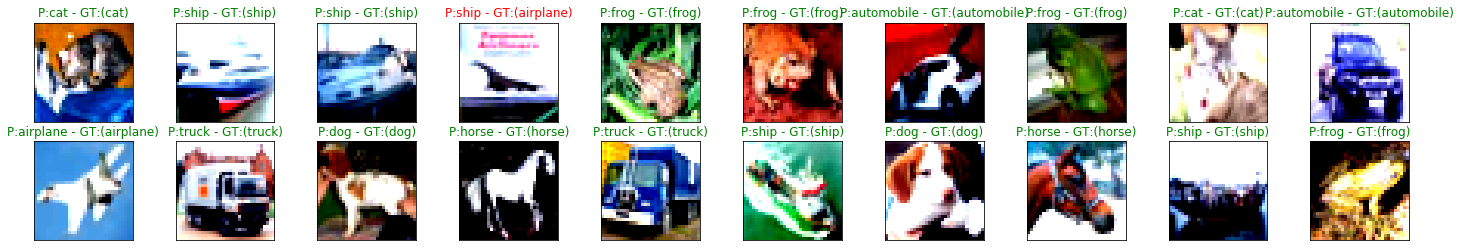

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images.numpy()

# move model inputs to cuda, if GPU available
images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not gpu_on else np.squeeze(preds_tensor.cpu().numpy())
 
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("P:{} - GT:({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))


### Plot Loss

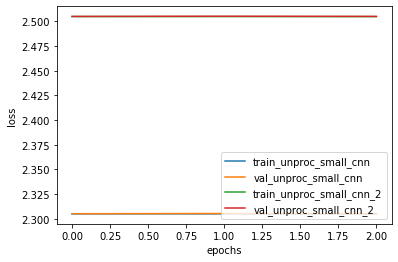

In [58]:
epochs_axis = [*range(n_epochs)]

acc_legend = []
for key in history_plot:
    plt.plot(epochs_axis, history_plot[key][0])
    plt.plot(epochs_axis, history_plot[key][1])
    acc_legend += ['train_'+key, 'val_'+key]

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(acc_legend, loc='lower right')
plt.show()


### How can we improve the model, what are the weakenesses?